In [32]:
folder_path = "../Reddit_Scraped_Comments/"
visuals_output_path = "./visuals/"
output_path = "./output/"
file1 = "anti_lockdown_comments.csv"
file2 = "corona_lockdown_comments.csv"
file3 = "covid19_lockdown_comments.csv"

In [33]:
!pip install pyLDAvis

In [34]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import nltk
nltk.download('stopwords') #download if don't have yet
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lindy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
# Read in files
df1 = pd.read_csv(folder_path + file1)
df2 = pd.read_csv(folder_path + file2)
df3 = pd.read_csv(folder_path + file3)

<h1>Cleaning Data</h1>

In [36]:
# Drop columns with removed comments
df1 = df1[df1.comment != "[removed]"]
df2 = df2[df2.comment != "[removed]"]
df3 = df3[df3.comment != "[removed]"]

In [37]:
# Combine the comments
list1 = df1["comment"].tolist()
list2 = df2["comment"].tolist()
list3 = df3["comment"].tolist()
comments = list1 + list2 + list3

In [38]:
# Define helper functions for data cleaning

def remove_special_chars(text):
    remove_chars = '[0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
    return re.sub(remove_chars, ' ', text)

def remove_digit_strings(text):
    return re.sub(r'\d+', '', text)

def remove_links(text):
    return re.sub(r'http\S+', '', text)

def clean_text(text):
    result_text = remove_links(text)
    result_text = remove_digit_strings(result_text)
    result_text = remove_special_chars(result_text)
    result_text = result_text.lower()
    return result_text

In [39]:
# Clean texts
for i in range(len(comments)):
    comments[i] = clean_text(comments[i])

<h1>Tokenizing Data</h1>

In [40]:
# Get custom stopwords
content = []
f = open("./stopwords.txt", encoding = 'utf-8')
# perform file operations
for line in f:
    content.append(line)
f.close()

custom_stopwords = []
for line in content:
    wordlist = line.split(",")
    for word in wordlist:
        custom_stopwords.append(word)

In [41]:
# Stopwords
stop_words = stopwords.words('english')
exclude_words = stop_words

exclude_words_extra = ["covid","lockdown","corona","pandemic","let","im","ive","would","one","also","to","say","day","well","month","thing","take","see","get","go"]

# Exclude custom stopwords
exclude_words.extend(custom_stopwords)
exclude_words.extend(exclude_words_extra)

In [42]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(comments))

In [43]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['people', 'like', 'this', 'everywhere', 'in', 'the', 'world', 'difference', 'is', 'are', 'there', 'enough', 'to', 'gain', 'political', 'power']


In [44]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in exclude_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [45]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['people', 'everywhere', 'world', 'difference', 'enough', 'gain', 'political', 'power']]


In [46]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


[[('difference', 1),
  ('enough', 1),
  ('everywhere', 1),
  ('gain', 1),
  ('people', 1),
  ('political', 1),
  ('power', 1),
  ('world', 1)]]

<h1>LDA Model</h1>

In [47]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

# supporting function 2
def compute_perplexity_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    perplexity_score = lda_model.log_perplexity(corpus_sets[i])
    
    return perplexity_score

In [48]:
# Build LDA model
num_topics = 4
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [49]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"case" + 0.014*"death" + 0.013*"country" + 0.012*"need" + '
  '0.012*"even" + 0.011*"spread" + 0.011*"vaccine" + 0.010*"number" + '
  '0.010*"lockdown" + 0.010*"way"'),
 (1,
  '0.024*"comment" + 0.022*"question" + 0.021*"hospital" + 0.020*"lock" + '
  '0.020*"post" + 0.019*"likely" + 0.019*"see" + 0.018*"model" + 0.018*"base" '
  '+ 0.018*"believe"'),
 (2,
  '0.055*"people" + 0.020*"time" + 0.019*"think" + 0.018*"make" + 0.017*"work" '
  '+ 0.016*"go" + 0.014*"much" + 0.012*"test" + 0.011*"use" + 0.011*"look"'),
 (3,
  '0.021*"know" + 0.017*"get" + 0.016*"good" + 0.016*"seem" + 0.014*"month" + '
  '0.013*"place" + 0.012*"report" + 0.012*"mean" + 0.012*"infect" + '
  '0.012*"care"')]


In [50]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.907944570148066

Coherence Score:  0.5991910291680547


In [51]:
optimal_model = lda_model
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.015*"case" + 0.014*"death" + 0.013*"country" + 0.012*"need" + '
  '0.012*"even" + 0.011*"spread" + 0.011*"vaccine" + 0.010*"number" + '
  '0.010*"lockdown" + 0.010*"way"'),
 (1,
  '0.024*"comment" + 0.022*"question" + 0.021*"hospital" + 0.020*"lock" + '
  '0.020*"post" + 0.019*"likely" + 0.019*"see" + 0.018*"model" + 0.018*"base" '
  '+ 0.018*"believe"'),
 (2,
  '0.055*"people" + 0.020*"time" + 0.019*"think" + 0.018*"make" + 0.017*"work" '
  '+ 0.016*"go" + 0.014*"much" + 0.012*"test" + 0.011*"use" + 0.011*"look"'),
 (3,
  '0.021*"know" + 0.017*"get" + 0.016*"good" + 0.016*"seem" + 0.014*"month" + '
  '0.013*"place" + 0.012*"report" + 0.012*"mean" + 0.012*"infect" + '
  '0.012*"care"')]


In [52]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [53]:
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(4):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

case                 0.015
death                0.014
country              0.013
need                 0.012
even                 0.012
spread               0.011
vaccine              0.011
number               0.010
lockdown             0.010
way                  0.010
Topic 1 |---------------------

comment              0.024
question             0.022
hospital             0.021
lock                 0.020
post                 0.020
likely               0.019
see                  0.019
model                0.018
base                 0.018
believe              0.018
Topic 2 |---------------------

people               0.055
time                 0.020
think                0.019
make                 0.018
work                 0.017
go                   0.016
much                 0.014
test                 0.012
use                  0.011
look                 0.011
Topic 3 |---------------------

know                 0.021
get

<h1>Data Output - Dominant Topic</h1>

In [54]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.3851,"case, death, country, need, even, spread, vacc...","[people, everywhere, world, difference, enough..."
1,1,0.0,0.4570,"case, death, country, need, even, spread, vacc...","[certainly, enough, cause, massive, surge, cas..."
2,2,0.0,0.4282,"case, death, country, need, even, spread, vacc...","[largely, absent, read, small, group, largely,..."
3,3,3.0,0.4180,"know, get, good, seem, month, place, report, m...","[percentage, population, easily, deceive, fall..."
4,4,0.0,0.5859,"case, death, country, need, even, spread, vacc...","[short, answer, look, pass, long, answer, need..."
5,5,0.0,0.3965,"case, death, country, need, even, spread, vacc...","[think, country, riddled, moron, nope, stupidi..."
6,6,0.0,0.3350,"case, death, country, need, even, spread, vacc...","[enter, chat]"
7,7,0.0,0.4059,"case, death, country, need, even, spread, vacc...","[see, united_state]"
8,8,0.0,0.5119,"case, death, country, need, even, spread, vacc...","[introduce, president, united_state]"
9,9,0.0,0.5609,"case, death, country, need, even, spread, vacc...","[safe, prediction, link, eventually, come, rus..."


In [55]:
# Export to CSV
df_dominant_topic.to_csv(output_path + "reddit_overall_dominant_topics.csv")

<h1>Data Visualization</h1>

<h3>PyLDAVis</h3>

In [56]:
# PyLDAVis

import pyLDAvis.gensim_models as gensimvis
import pickle 

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = visuals_output_path + "reddit-overall-pyldavis-vizprep"

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, visuals_output_path + "reddit-overall-pyldavis.html")

LDAvis_prepared

C:\Users\Lindy\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.345262  0.099620       1        1  38.773616
2      0.209674  0.282835       2        1  31.782937
3      0.052572 -0.224735       3        1  20.415192
1      0.083016 -0.157720       4        1   9.028255, topic_info=         Term         Freq        Total Category  logprob  loglift
4      people  2587.000000  2587.000000  Default  30.0000  30.0000
471      time   950.000000   950.000000  Default  29.0000  29.0000
133     think   890.000000   890.000000  Default  28.0000  28.0000
192      know   637.000000   637.000000  Default  27.0000  27.0000
35       make   832.000000   832.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
275       ask   109.025566   109.548193   Topic4  -4.7958   2.4000
767   require   111.721281   112.294281   Topic4  -4.7714   2.3997
144      link   101.939819   102.441877   Topic4  -4.8630   2.3999
1109  confirm   108.052630   108.663478   Topic4  -4.8048   2.3992
1081    learn   103.277454   103.821376   Topic4  -4.8500   2.3996

[168 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
956       4  0.993573   action
603       4  0.998659    allow
372       4  0.997437  article
275       4  0.994996      ask
403       1  0.998381      bad
...     ...       ...      ...
897       1  0.997574     well
256       3  0.999116    whole
126       2  0.998799     work
7         3  0.998692    world
253       2  0.999327     year

[150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

<h3>Frequency Distribution of Word Counts in Documents</h3>

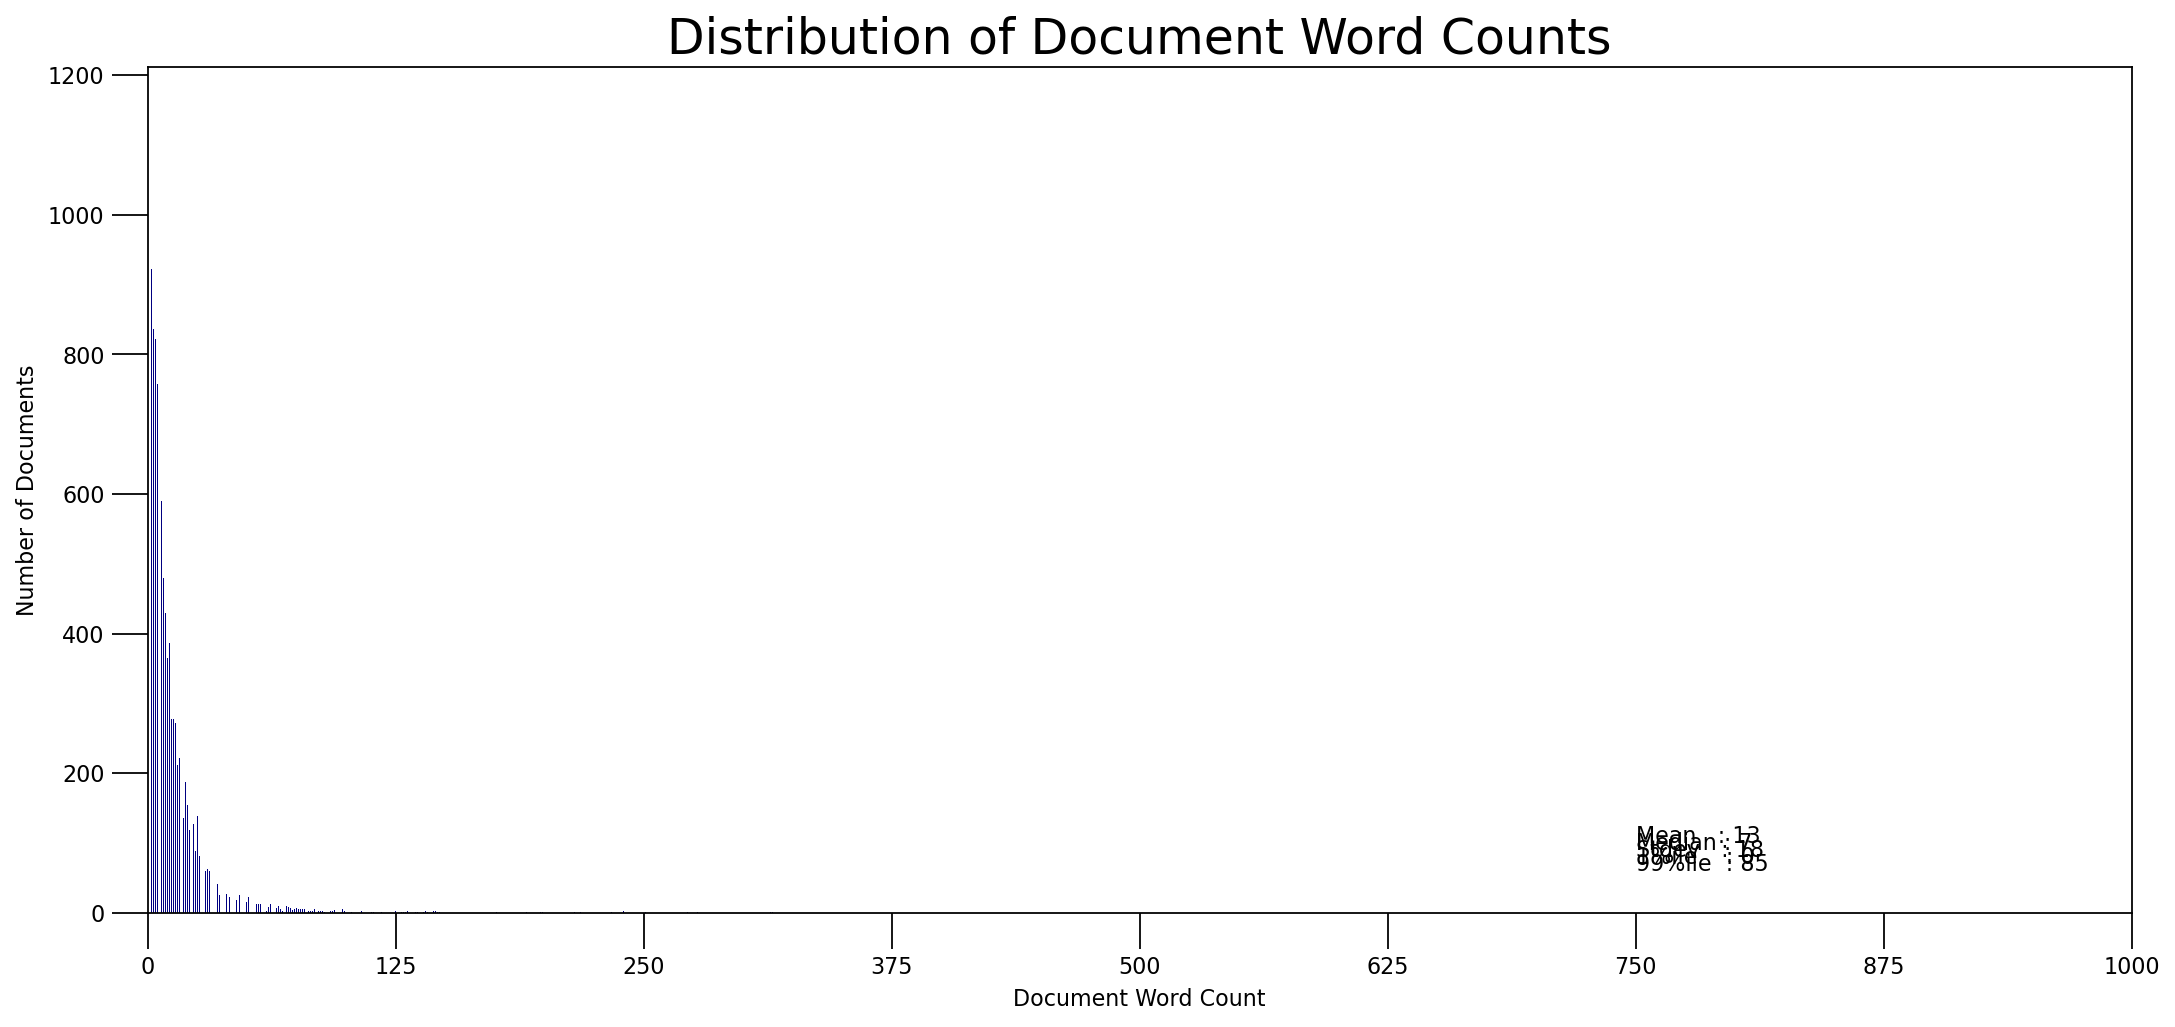

In [57]:
# Distribution of Document Word Counts

doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.savefig(visuals_output_path + "reddit_overall_wordcountdist.png")
plt.show()

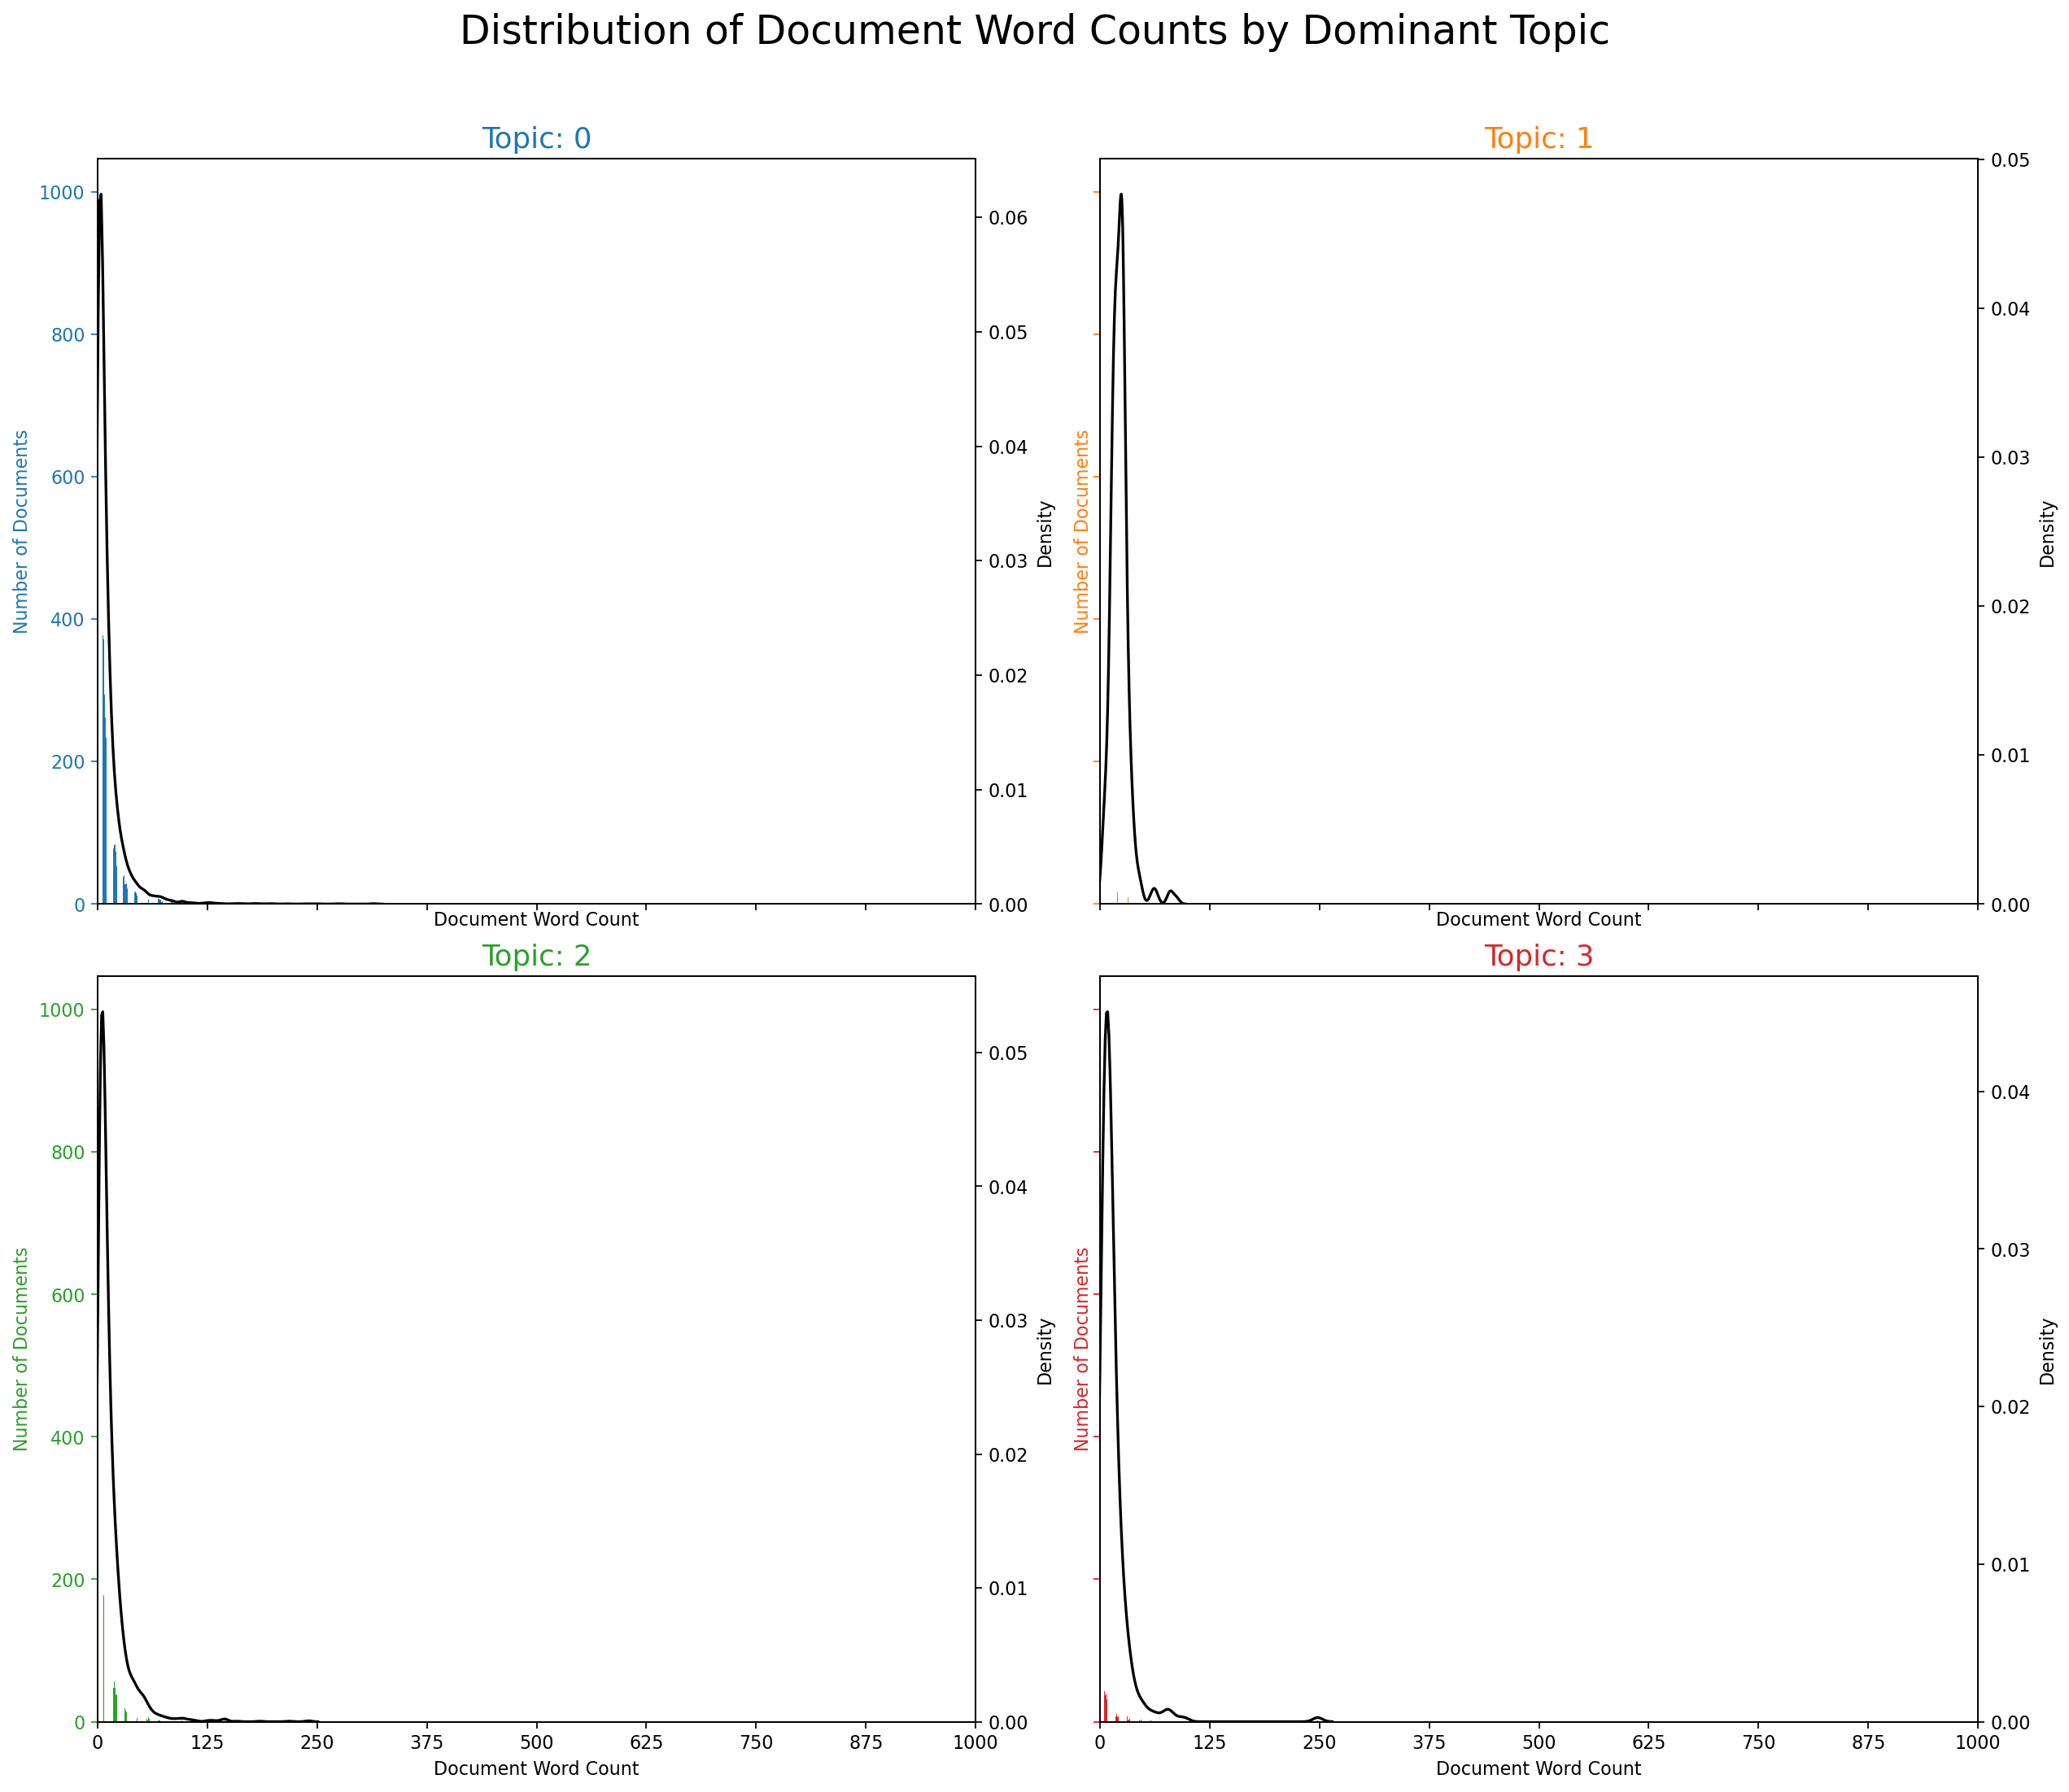

In [58]:
# Distribution of Document Word Counts by Dominant Topic

import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.savefig(visuals_output_path + "reddit_overall_wordcountdist_by_dominant_topic.png")
plt.show()

<h3>Word Clouds of Top N Keywords in Each Topic</h3>

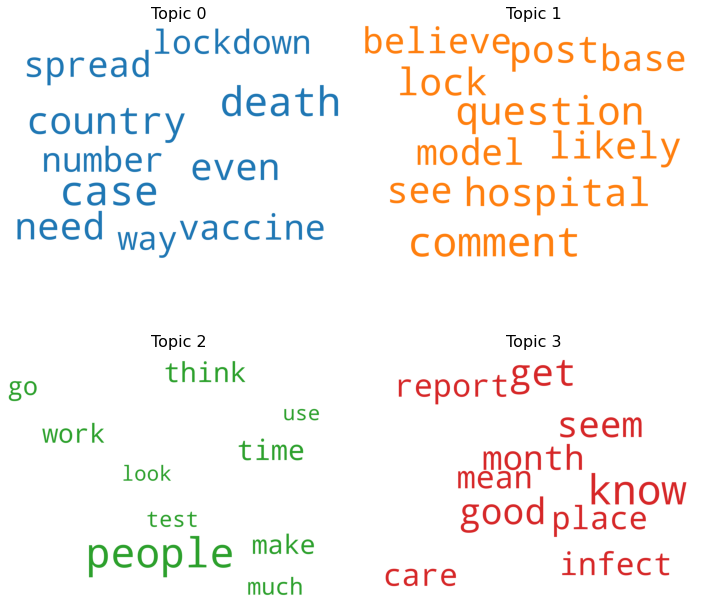

In [59]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig(visuals_output_path + "reddit_overall_wordcloud.png")
plt.show()

<h3>Word Counts of Topic Keywords</h3>

C:\Users\Lindy\AppData\Local\Temp/ipykernel_10904/516424954.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


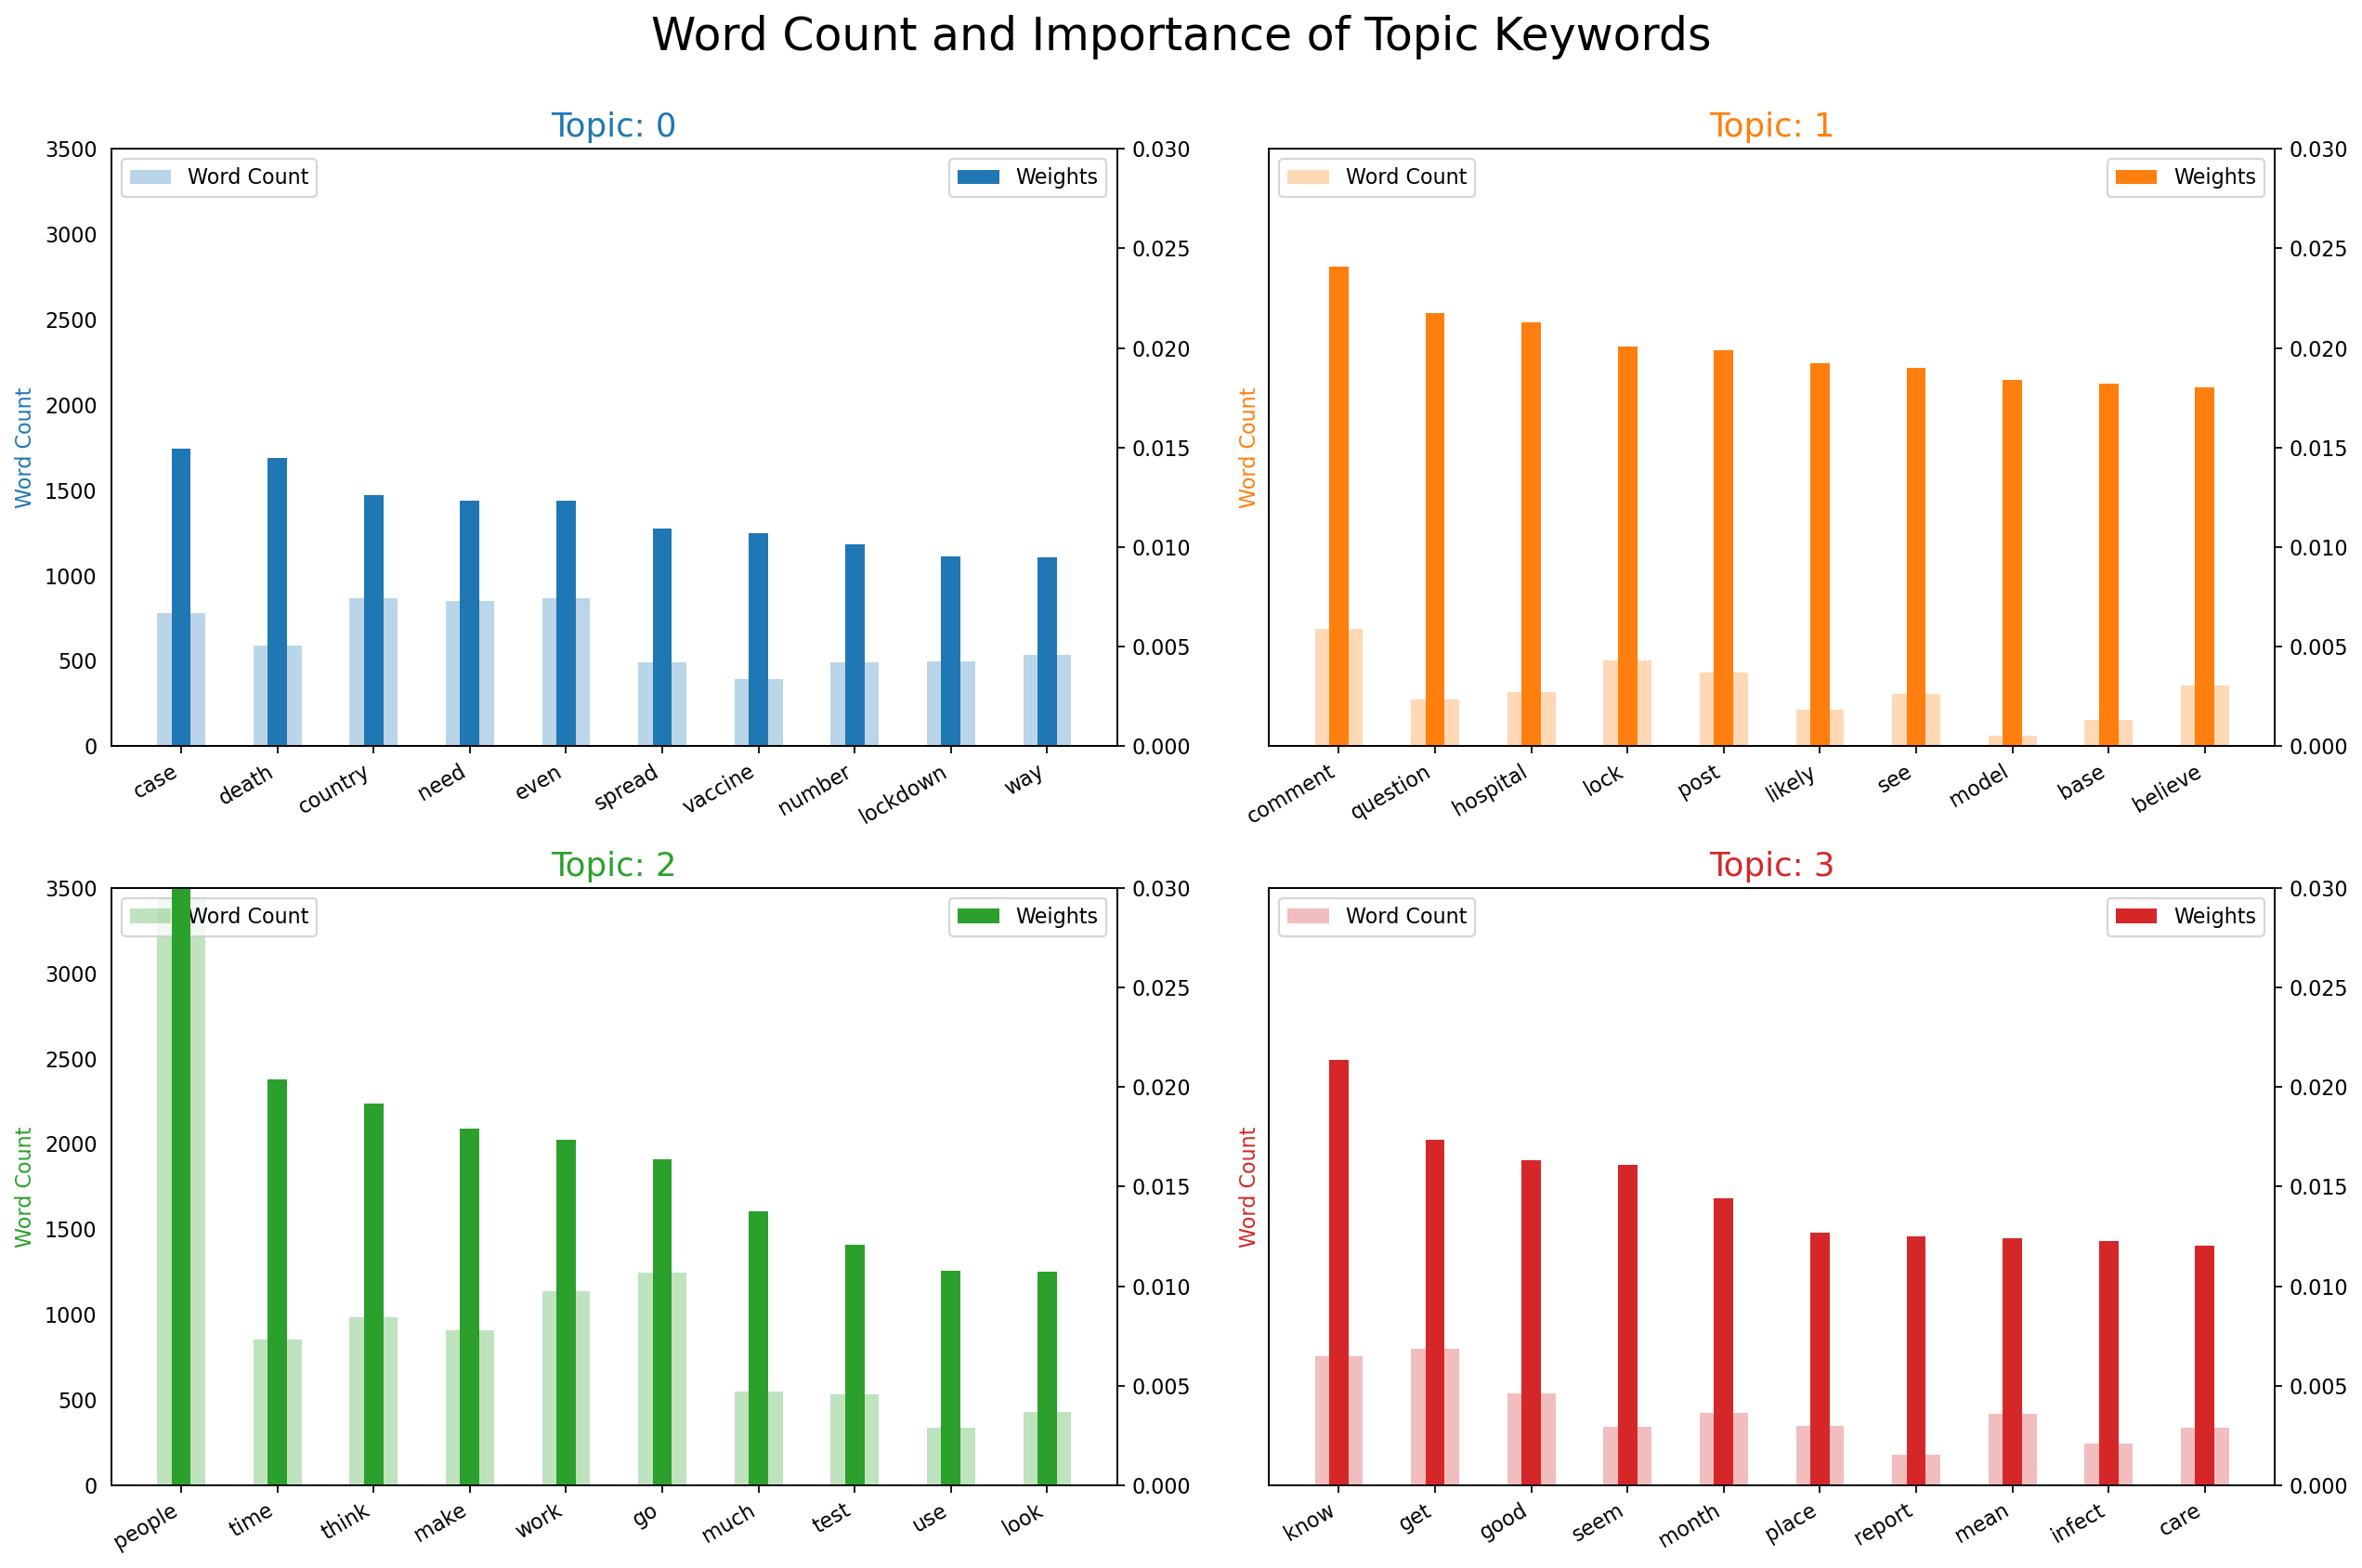

In [60]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.savefig(visuals_output_path + "reddit_overall_wordcounts.png")
plt.show()

<h3>Most Discussed Topics</h3>

In [61]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

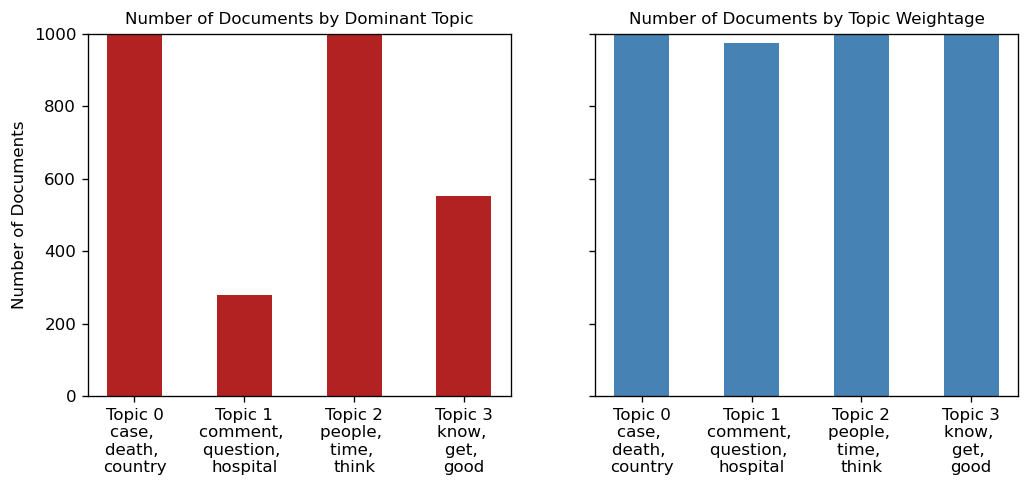

In [62]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.savefig(visuals_output_path + "reddit_overall_dominant_topics.png")
plt.show()